<a href="https://colab.research.google.com/github/Aayush-Jain01/CIFAR10_Model/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [3]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')


In [4]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['dog', 'automobile', 'deer', 'horse', 'truck', 'airplane', 'frog', 'bird', 'ship', 'cat']


In [5]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['3585.png', '0464.png', '4187.png', '2879.png', '1469.png']


In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [7]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())


torch.Size([32, 32, 3])


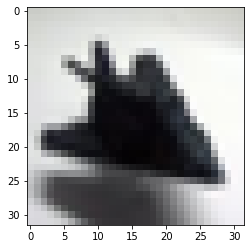

In [8]:
import matplotlib.pyplot as plt
img, label = dataset[0]
image = torch.permute(img, (1, 2, 0))
print(image.shape)
plt.imshow(image)

In [9]:
random_seed = 42
torch.manual_seed(random_seed)

In [10]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [11]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
def convolution(image, kernel):
  h_i, w_i = image.shape
  h_k, w_k = kernel.shape
  o_h, o_w = h_i - h_k + 1, w_i - w_k + 1
  output = torch.zeros(o_h, o_w)
  for h in range(o_h):
    for w in range(o_w):
      output[h, w] = torch.sum(image[h:h+h_k, w:w+w_k] * kernel)
  return output

In [14]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

convolution(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), #output = floor((input-size(32)+2*padding-kernel_size/stride) + 1)
    nn.MaxPool2d(2, 2)   #Channels remain same just height and width decreases to same formula as above
)

In [17]:
class Training(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    val_loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return val_loss, acc

def accuracy(output, labels):
  _, preds = torch.max(output, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))



  



In [18]:
class Layers(Training):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
        nn.Flatten(), 
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10))
  def forward(self, xb):
    return self.network(xb)

In [19]:
model = Layers()
model

Layers(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024

In [23]:
torch.cuda.is_available()

True

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:
device = get_default_device()

In [29]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [31]:

def train(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_loss = []
    val_loss = []
    val_acc = []
    i = 1
    for batch in train_loader:
      loss = model.training_step(batch)
      train_loss.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    for batch in val_loader:
      loss = model.validation_step(batch)[0]
      acc = model.validation_step(batch)[1]
      val_loss.append(loss)
      val_acc.append(acc)
    print(epoch)
    print(sum(val_loss)/len(val_loss), sum(val_acc)/len(val_acc))
  return sum(val_loss)/len(val_loss), sum(val_acc)/len(val_acc)

In [34]:
model = to_device(Layers(), device)

In [35]:
train(10, 0.001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
tensor(1.4638, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.4649)
1
tensor(1.0805, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6112)
2
tensor(0.9168, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6653)
3
tensor(0.8154, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.7121)
4
tensor(0.7382, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.7469)
5
tensor(0.7423, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.7535)
6
tensor(0.7880, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.7537)
7
tensor(0.7547, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.7637)
8
tensor(0.8382, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.7624)
9
tensor(0.9629, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.7585)


(tensor(0.9629, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.7585))